<a href="https://colab.research.google.com/github/sheetalojha/AI-Explainablity/blob/main/AIExplainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import PIL
import numpy as np
from PIL import Image
from imageio import imread
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io
from skimage import segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression

In [3]:
#pretrained Inception V3 model
inceptionV3 = tf.keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

96116736/96112376 [==============================] - 3s 0us/step


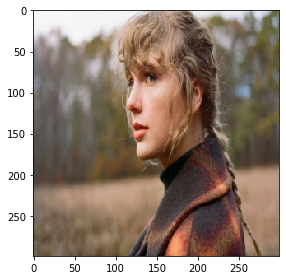

In [5]:
path = "/content/1.jpg"
img = skimage.io.imread(path)
#resize to (299, 299) for inception V3 
img=skimage.transform.resize(img, (299, 299))
img1 = (img-0.5)*2
skimage.io.imshow(img)

In [6]:
#get prediction for this image top 5 predicted classes
preds = inceptionV3.predict(img1[np.newaxis,:,:,:])
decode_predictions(preds)[0] 
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes

49152/35363 [=========================================] - 0s 0us/step


array([824, 474, 568, 735, 501])

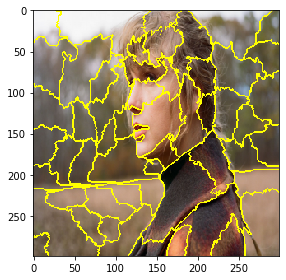

In [7]:
superpixels = skimage.segmentation.quickshift(img1, kernel_size=4,max_dist=200, ratio=0.2)
skimage.io.imshow(skimage.segmentation.mark_boundaries(img, superpixels))

In [8]:
#creating 150 random pertuberations
num_perturb = 150
num_superpixels = np.unique(superpixels).shape[0]
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

In [9]:
def perturb_image(img,perturbation,superpixels):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(superpixels.shape)
  for active in active_pixels:
      mask[superpixels == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

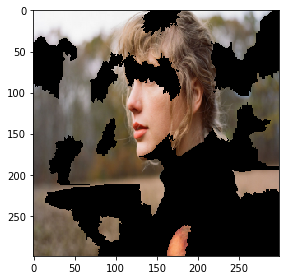

In [10]:
skimage.io.imshow(perturb_image(img,perturbations[0],superpixels))

In [11]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(img,pert,superpixels)
  pred = inceptionV3.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1, 1000)

In [12]:
#distance b/w the generated images and original image
#the original image has all the superpixels active
og_img = np.ones(num_superpixels)[np.newaxis,:] 
distances = sklearn.metrics.pairwise_distances(perturbations,og_img, metric='euclidean').ravel()

In [13]:
distances.shape

(150,)

In [14]:
#using kernel function to calculate weights for superpixels
kernel_width = 0.25
weights = np.sqrt(np.exp(-distances**2)/(kernel_width**2))

In [15]:
weights.shape

(150,)

In [16]:
#simpler model to explain the predictions
class_to_explain = top_pred_classes[0]
model = LinearRegression()
model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = model.coef_[0]
coeff

array([ 1.07971734e-03, -5.26143966e-04,  5.12289010e-04,  9.93664986e-04,
       -2.16004972e-03,  7.34805776e-04,  1.13264845e-03, -1.86655979e-03,
        9.98624712e-04, -8.74964074e-05,  1.33604493e-03,  2.66921562e-04,
        2.90078164e-03,  5.11069173e-04,  2.27025279e-03,  5.63196656e-04,
        2.09781568e-03,  2.82658396e-03,  1.72053954e-03,  2.11421220e-03,
       -2.89321925e-03,  3.00207846e-04,  4.71228944e-03, -1.23510699e-03,
       -9.83912834e-04,  3.72581534e-04, -5.45572628e-04,  1.32428851e-03,
       -4.07655588e-03, -5.93563804e-04, -6.87985572e-04, -1.30553604e-03,
       -7.35309621e-04, -1.60050164e-03, -5.23577325e-06,  8.13025062e-04,
        1.03187542e-03,  1.74880139e-03,  2.60774054e-03,  2.83712553e-03,
        3.09590191e-04,  1.15149279e-04,  1.04125290e-03,  1.79964463e-03,
        5.19132328e-04,  8.28947489e-04, -2.18505840e-03,  1.14239093e-03,
       -1.10668179e-03, -2.04308330e-03, -3.45816008e-04, -3.62126773e-05,
        1.90425066e-03, -

In [17]:
#top 4 super pixels
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([17, 39, 12, 22])

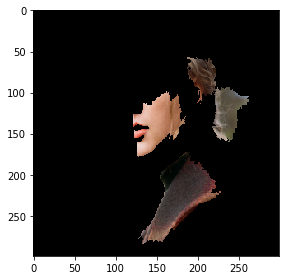

In [18]:
mask = np.zeros(num_superpixels)
#Activate top superpixels 
mask[top_features]= True 
skimage.io.imshow(perturb_image(img,mask,superpixels))